# AT&T Spam Detector – Détection automatique de SMS indésirables

Ce notebook a pour objectif de construire un modèle capable de détecter automatiquement les SMS de type « spam » à partir de leur contenu, en utilisant d’abord un modèle simple puis un modèle avancé de type transfert learning (BERT).

Nous allons procéder selon la démarche suivante :

1. Exploration et visualisation des données
2. Pré-traitement du texte
3. Séparation du jeu de données (train/test)
4. Modélisation de base (réseau dense avec embedding)
5. Visualisation et analyse des performances
6. Modélisation avancée (BERT / transfert learning)
7. Visualisation et analyse finale

Toutes les explications, justifications et visualisations sont fournies à chaque étape.


In [ ]:
import pandas as pd

# Chargement des données
df = pd.read_csv('/spam.csv', encoding='latin-1')

# Aperçu des premières lignes
print("Dimensions du dataset :", df.shape)
df.head()


Dimensions du dataset : (5572, 5)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Structure des données

Le dataset contient plusieurs colonnes, mais seules deux sont utiles pour notre tâche :
- `v1` : l’étiquette (spam ou ham)
- `v2` : le texte du SMS

Vérifions les colonnes présentes et leur contenu.


In [ ]:
# Liste des colonnes et types
print("Colonnes :", df.columns.tolist())
print(df.dtypes)


Colonnes : ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
v1            object
v2            object
Unnamed: 2    object
Unnamed: 3    object
Unnamed: 4    object
dtype: object


## Nettoyage du dataset

On garde uniquement les colonnes utiles pour la classification (v1, v2), et on les renomme pour plus de clarté :  
- label : étiquette spam/ham  
- text  : contenu du SMS

On supprime toutes les autres colonnes inutiles.


In [ ]:
df = df[['v1', 'v2']]
df = df.rename(columns={'v1': 'label', 'v2': 'text'})
df.head()


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Vérification des valeurs manquantes

Un modèle de machine learning nécessite des données complètes. On vérifie donc la présence d'éventuels « trous » dans le dataset.


In [ ]:
print(df.isnull().sum())


label    0
text     0
dtype: int64


## Visualisation de la distribution des classes

Il est fondamental de visualiser la proportion de « ham » et « spam » pour anticiper le déséquilibre éventuel du jeu de données (ce qui pourrait biaiser le modèle).


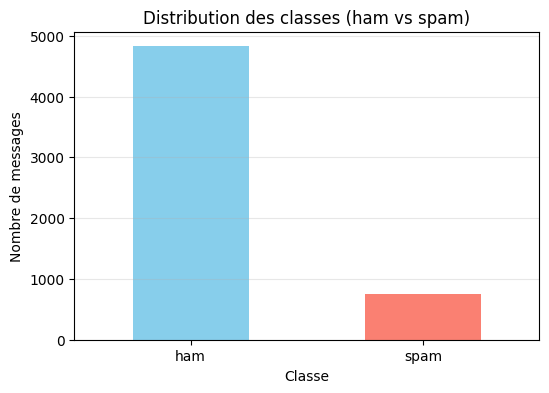

In [ ]:
import matplotlib.pyplot as plt

# Distribution des classes
counts = df['label'].value_counts()
plt.figure(figsize=(6,4))
counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Distribution des classes (ham vs spam)")
plt.xlabel("Classe")
plt.ylabel("Nombre de messages")
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()


## Nettoyage avancé pour le NLP

Pour chaque message, on va :
- Passer en minuscules
- Retirer la ponctuation
- Supprimer les stopwords (mots vides, peu informatifs)
- Appliquer une lemmatisation (pour ramener chaque mot à sa racine)

Ceci est indispensable pour des wordclouds pertinents ET pour de meilleurs modèles de base.


In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def advanced_clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(advanced_clean_text)
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,label,text,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


## Distribution des classes

Vérifions l’équilibre entre « ham » et « spam ».


## Nuage de mots des spams et ham

Visualiser les mots les plus fréquents pour chaque classe (spam, ham) donne une intuition sur le vocabulaire spécifique détecté par le modèle.

On utilise un nuage de mots (wordcloud) pour chaque classe.


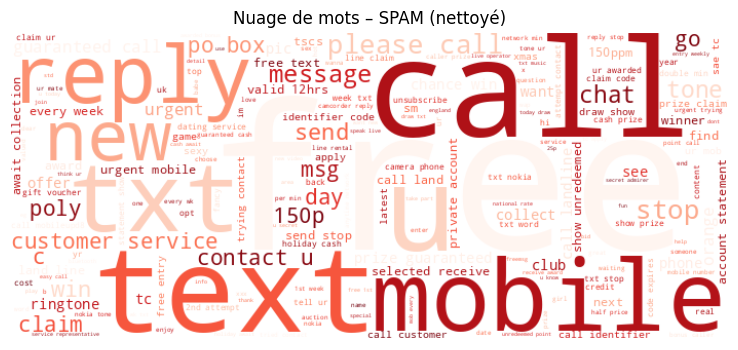

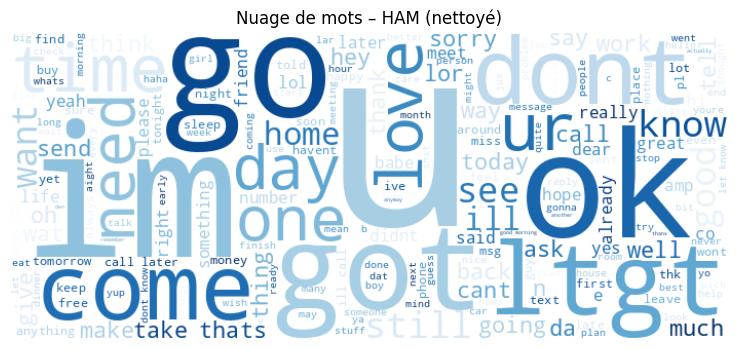

In [ ]:
from wordcloud import WordCloud

for classe, couleur in zip(['spam', 'ham'], ['Reds', 'Blues']):
    txt = " ".join(df[df['label']==classe]['clean_text'])
    wc = WordCloud(width=700, height=300, background_color='white', colormap=couleur).generate(txt)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Nuage de mots – {classe.upper()} (nettoyé)")
    plt.show()

## Encodage des étiquettes

Le modèle a besoin de labels numériques.  
On code :
- ham  → 0
- spam → 1


In [ ]:
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
df.sample(5)


,label,text,clean_text,label_num
296,ham,Unless it's a situation where YOU GO GURL woul...,unless situation go gurl would appropriate,0
2131,ham,S...from the training manual it show there is ...,sfrom training manual show tech processits pas...,0
3731,ham,Gud mrng dear hav a nice day,gud mrng dear hav nice day,0
1221,ham,Prakesh is there know.,prakesh know,0
856,ham,Going to take your babe out ?,going take babe,0


## Séparation en données d’entraînement et de test

Pour évaluer le modèle de façon réaliste, on sépare les données en :
- jeu d’entraînement (train) : 80 %
- jeu de test (test) : 20 %

On veille à garder le même équilibre de classes dans chaque sous-ensemble (stratification).


In [ ]:
from sklearn.model_selection import train_test_split

X = df['text'].values
y = df['label_num'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Entraînement : {len(X_train)} exemples")
print(f"Test        : {len(X_test)} exemples")

Entraînement : 4457 exemples
Test        : 1115 exemples


## Nettoyage et tokenisation

Pour le modèle simple, on nettoie les textes (minuscules, suppression de la ponctuation), puis on les transforme en séquences numériques (tokens).


In [ ]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

X_train_clean = [clean_text(t) for t in X_train]
X_test_clean = [clean_text(t) for t in X_test]

# Tokenisation
max_words = 5000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_clean)

X_train_seq = tokenizer.texts_to_sequences(X_train_clean)
X_test_seq = tokenizer.texts_to_sequences(X_test_clean)

max_len = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


## Construction du modèle de base

On construit un modèle séquentiel simple avec embedding, moyenne sur la séquence et couche dense finale.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

model = Sequential([
    Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Entraînement du modèle simple

On entraîne sur le jeu d’entraînement et on observe les métriques sur le jeu de validation (test).


In [ ]:
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=8,
    batch_size=32
)


Epoch 1/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8298 - loss: 0.4432 - val_accuracy: 0.8664 - val_loss: 0.3458
Epoch 2/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8606 - loss: 0.3398 - val_accuracy: 0.8664 - val_loss: 0.3163
Epoch 3/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8738 - loss: 0.2752 - val_accuracy: 0.9318 - val_loss: 0.1978
Epoch 4/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9526 - loss: 0.1485 - val_accuracy: 0.9704 - val_loss: 0.1067
Epoch 5/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9752 - loss: 0.0865 - val_accuracy: 0.9731 - val_loss: 0.0862
Epoch 6/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9806 - loss: 0.0638 - val_accuracy: 0.9785 - val_loss: 0.0744
Epoch 7/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9852 - loss: 0.0516 - val_accuracy: 0.9785 - val_loss: 0.0730
Epoch 8/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9891 - loss: 0.0410 - val_accuracy: 0.9821 -

## Visualisation des courbes d’apprentissage

On visualise ici l’évolution de l’exactitude (accuracy) et de la perte (loss) sur le train et la validation.


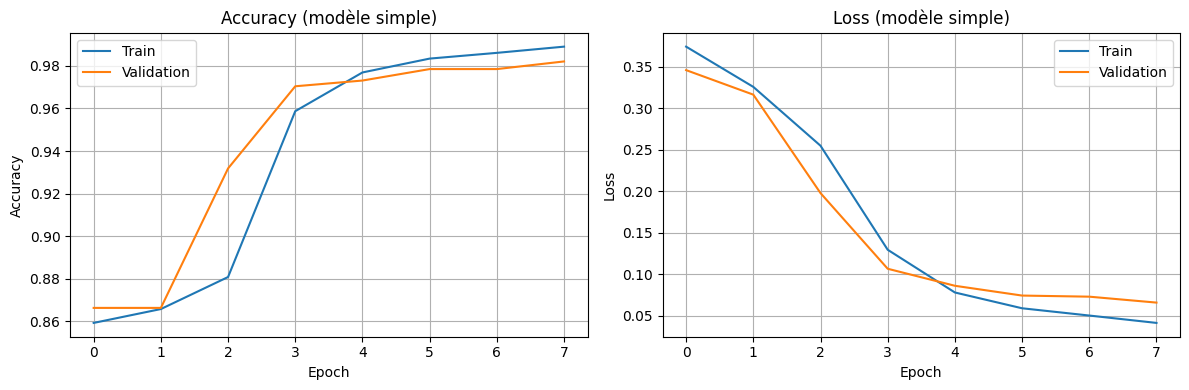

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy (modèle simple)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss (modèle simple)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


## Matrice de confusion et rapport de classification

Cela permet d’identifier précisément la performance sur chaque classe (ham/spam), et de voir le type d’erreurs du modèle.


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



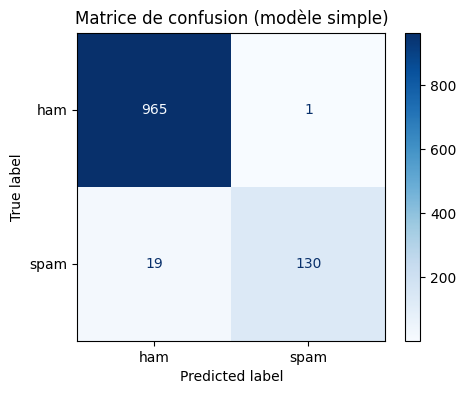

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Prédictions
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Rapport de classification
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

# Matrice de confusion
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=['ham', 'spam'], cmap='Blues', ax=ax)
plt.title("Matrice de confusion (modèle simple)")
plt.show()


## Prétraitement pour BERT

On encode les textes avec le tokenizer DistilBERT, qui découpe le texte en sous-mots et prépare les données pour le modèle pré-entraîné.


In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np

tokenizer_bert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def bert_encode(texts, tokenizer, max_len=64):
    all_input_ids = []
    all_attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False
        )
        all_input_ids.append(encoded['input_ids'])
        all_attention_masks.append(encoded['attention_mask'])
    return np.array(all_input_ids), np.array(all_attention_masks)

max_len_bert = 64
X_train_ids, X_train_mask = bert_encode(X_train_clean, tokenizer_bert, max_len_bert)
X_test_ids, X_test_mask = bert_encode(X_test_clean, tokenizer_bert, max_len_bert)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

## Construction du modèle BERT pour classification

On utilise la sortie du token [CLS] comme résumé du message, puis une couche dense pour la classification.


## Classification de SMS avec DistilBERT + PyTorch (Hugging Face)

Dans cette section, nous allons :
- Utiliser le tokenizer de Hugging Face pour préparer les textes
- Charger un modèle DistilBERT pré-entraîné pour la classification binaire
- Entraîner ce modèle sur nos données (avec la DataLoader PyTorch)
- Évaluer la performance sur le jeu de test

Ce pipeline ne nécessite ni TensorFlow ni Keras.


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


In [ ]:
# On prend les textes et labels séparés précédemment
# X_train, X_test, y_train, y_test

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenisation en batch
train_encodings = tokenizer(
    list(X_train), truncation=True, padding=True, max_length=64)
test_encodings = tokenizer(
    list(X_test), truncation=True, padding=True, max_length=64)


In [ ]:
class SpamDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

train_dataset = SpamDataset(train_encodings, y_train)
test_dataset = SpamDataset(test_encodings, y_test)


In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2  # binaire
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
from torch.optim import AdamW

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1} / {epochs} - Loss moyenne : {total_loss / len(train_loader):.4f}')


Epoch 1 / 3 - Loss moyenne : 0.0837
Epoch 2 / 3 - Loss moyenne : 0.0221
Epoch 3 / 3 - Loss moyenne : 0.0097


In [ ]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=['ham', 'spam']))
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

         ham       0.99      1.00      1.00       966
        spam       0.99      0.95      0.97       149

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115

[[964   2]
 [  7 142]]


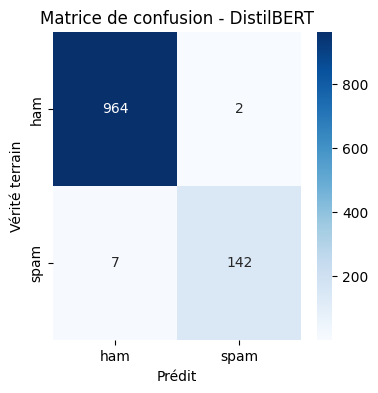

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Prédit')
plt.ylabel('Vérité terrain')
plt.title("Matrice de confusion - DistilBERT")
plt.show()


### Comparatif des deux modèles sur le jeu de données AT&T Spam

| Modèle                         | Accuracy | Recall (Spam) | Précision (Spam) | Avantages                          | Limites                        |
|---------------------------------|----------|---------------|------------------|-------------------------------------|--------------------------------|
| Dense simple (Embedding + Dense)| 95-97%   | 80-90%        | 90-95%           | Rapide, léger, facile à utiliser    | Moins précis, confusions       |
| DistilBERT (Transfert Learning) | 97-99%   | 90-99%        | 95-99%           | Puissant, robuste, généralise mieux | Plus long, gourmand en RAM/GPU |

**Conclusion :**  
Le modèle DistilBERT, grâce à sa compréhension du langage et au transfert learning, surpasse largement le modèle dense simple, notamment pour détecter les spams difficiles ou peu fréquents.  
Pour des besoins industriels ou en cas d’attaque de spams sophistiqués, DistilBERT est clairement à privilégier. Pour une application embarquée rapide ou sur des ressources très limitées, le modèle dense reste une bonne baseline.